# Semantic Latent models for Natural Language Generation
**Roberto Fierimonte** - 17/01/2018

---

## Goal:

To caputure semantic information about the sentence in the latent variables, leaving to the generative model the task of modelling the syntax. Latents learned in this way can be used e.g. in conditional text generation and text summarisation.

## State of the Art (far from being exaustive!):

### Stanford model (Bowman et al., 2016)

![](../latex-ucl-nlp-project/img/stanford.png)
- Encoder: LSTM + MLP
- Decoder: LSTM

KL term goes to 0 without annealing. Word dropout implemented to enrich generated sentences.

### Canvas model (Harshil and Barber, 2017)

- Encoder: LSTM + MLP
- Decoder: LSTM + Canvas

KL term goes to 0 without annealing. Word dropout not necessary in this case.

### TopicRNN model (Dieng et al., 2017)

- Encoder: MLP on Bag-of-Words representation
- Decoder: LSTM with gates on sentence embedding

At each time step the gate decides if the latents contribute to the next generated word or not. The contribution of the latents is categorical yes/no (the gate is drawn from a Bernoulli distribution).


## Work so far:

#### Restricted sentence in the recognition model

- **Rationale:** If we want the latent variables to encorporate more of the semantic of the sentence, why don't we we encode the latents using a restricted representation of the sentence in which we remove the common words. The hope is that doing so the latents will learn more about the key concepts (i.e. the semantic) of the sentence. The generative model remains the same and uses the whole sentence when decoding from the latents.

Multiple ways of restricting the sentences:
1. Removing the K most common words of the vocabulary (equal for all the sentences)
2. Select the words to remove from a list of common words (used in TopicRNN, equal for all the sentences)
3. Select the words to remove using TF-IDF (individual for each sentence, computationally expensive and more difficult to choose a threshold)


- **Results:** So far results have not been very promising. 
 Quantitatively we can observe a reduction in the impact of the KL term compared to the likelihood term in the ELBO, the more common words we remove, the less the KL term is impacting the ELBO. The overall value of the ELBO does not change much after enough training.

![](./comparison.png)

![](./kl_perc.png)

|  |  |  |  |
|---|---|---|---|
|__true x__| doug found cover that resembled his surroundings and attached them to his body so he could blend in with the terrain . | i 've got half a million bucks worth of computer equipment here . ''  | i ca n't deny that i 'm attracted to you , of course , but i 'm just not the relationship kind of guy .  |
|__restricted x (most common 50 words removed)__| doug found cover resembled surroundings attached them body blend terrain  | 've got half million bucks worth computer equipment here  | ca deny 'm attracted course 'm just relationship kind guy  |
|  |  |  |  |
|__Stanford (no restr) sampled__| his father darted with one to the venue , which from best he saw more than before eric stepped away . | i 'll be crushing every copy of a lot on my own . '' | i do n't know how i can beat me for , even if things sound happened , but then i think it was three . | 
|__Stanford (no restr) argmax__| he was about to get the hell out of his mind , and he was the one who had the same . | i 've been in a lot of time for a few days . | i do n't know what i 'm doing , but i 'm not sure what the hell is going to do with the guy . | 
|__Stanford (no restr) beam__| he looked at least a few moments of them , and he looked at least a long way out of it . | i 've got a lot of my time for a few days . | i do n't know what it 's going to do , but i 'm going to do it , but i need for me . |
|  |  |  |  |    
|__Stanford (restricted) sampled__| chapter thirty-seven a simple sight with the steely smashed back in travis 's lips , his blue eyes focused unreadable with concern as he stared plastered at the band 's | `` that 's all he wants to get up , and i 'm going to blow my tank and fall open to investigate the rest of my life to your | `` i wo n't let anyone do that i 've always said that existed . | 
|__Stanford (restricted) argmax__| the man was a little taller than the other , and he was a little bit taller than he was , and he was still wearing a t-shirt that was | `` i 'll be back in a few minutes , and i 'll be back in the morning , '' i said , and i could n't help but smile | i do n't know how much i 've been thinking about , but i 'm not sure what i 'm doing , but i do n't want to be with |
|__Stanford (restricted) beam__| he looked like an hour , a few minutes later , a few minutes ago . | `` i 've got a lot of the two hours . | `` i want to know that you , i ca n't want you , but i do n't want to do you . |
|  |  |  |  |
|__AUTR (no restr) sampled__| he had drifted up to block the world , keeping her distance as he realized now every part of this situation . | i 'm pretty sure of this food and clean up your speed . '' | i do n't know he might as well as well , makes anyone want , but can i picture out what it means . '' | 
|__AUTR (no restr) argmax__| he had a small , and he was a small , but he was the only way to the other side . | i 've got a lot of money and get a few minutes . '' | i do n't know what i 'm going to be honest , but i 'm not to the other person i 've ever met . | 
|__AUTR (no restr) beam__| he looked at the edge of the bed , but he seemed to be able to keep his eye on him . | i 've got a lot of money for a couple of days . '' | i do n't know what i 'm going to say , but i 'm not going to be a part of my life . '' | 
|  |  |  |  |
|__AUTR (restricted) sampled__| sato covered in black eyes burning white surfaces , which one knew the end of the surrounding area . | `` shit is our quarters , '' i said , a few weeks , '' he crooned . | `` i ca n't imagine what i have had told her and all . | 
|__AUTR (restricted) argmax__| the sun was still in the dark , and i was a small , but he was n't sure . | `` i 've got a lot of money , '' i said . | `` i 'm not sure i 'm not sure you 're not to be honest , i 'm not sure . '' | 
|__AUTR (restricted) beam__| he looked up at the edge of the room . | `` i 've got a lot of money . '' | `` i 'm not going to be honest with you . '' |
    
Qualitatively we can make few observations:
- Restricting the sentences in the recognition network does not prevent the model from generating common words, as this is demanded to the generative network.
- The canvas model is able to capture better semantics in the sentence (e.g. bucks translated to money), both using restricted and unrestricted sentences.
- Models that use a restricted representation in the recognition network are able to better open and close quotes.
- The restricted Stanford models seems to generate the least meaningful sentences.
  
 
#### Optimal factor for the KL term (thanks to Alex :) )

- **Rationale:** In the Stanford and the Canvas models we optimise a lower bound on the data likelihood:

$$
\def\given{\,\big|\,}
p\left(\mathbf{x}\right) \geq \mathbb{E}\left[\log\,p_\theta \left(\mathbf{x}\given z\right)\right]_{q_\phi\left(z\,|\,\mathbf{x}\right)} - D_{KL}\left[q_\phi\left(z\given\mathbf{x}\right)\|p\left(z\right)\right]\,.
$$

What if we want to minimise the joint probability of the input $x$ and the reconstruction $\hat{x}$? 

We have that (from David's sketch):

$$
\begin{split}
\log p\left(\hat{x}\given x\right) 
    &= 
    \log \int_z p\left(\hat{x}\given z\right)p\left(z\given x\right)\text{d}z\\
    &=
    \log \int_z q\left(z\given x, \hat{x}\right)\dfrac{p\left(\hat{x}\given z\right)p\left(z\given x\right)}{q\left(z\given x, \hat{x}\right)}\text{d}z\\
    &\geq
    \int_z q\left(z\given x, \hat{x}\right) \log \dfrac{p\left(\hat{x}\given z\right)p\left(z\given x\right)}{q\left(z\given x, \hat{x}\right)}\text{d}z\\
    &=
    -\int_z q\left(z\given x, \hat{x}\right) \log q\left(z\given x, \hat{x}\right)\text{d}z 
    + \int_z q\left(z\given x, \hat{x}\right) \log\left(p\left(\hat{x}\given z\right)p\left(z\given x\right)\right)\text{d}z\\
    &= -\int_z q\left(z\given x, \hat{x}\right) \log q\left(z\given x, \hat{x}\right)\text{d}z + \int_z q\left(z\given x, \hat{x}\right) \left[\log p\left(\hat{x}\given z\right) + \log p\left(x\given z\right) + \log p\left(z\right) - p\left(x\right)\right]\text{d}z
\end{split}\,.
$$

For a given sentence $x^n$ we have that:

$$
\begin{split}
\log p\left(\hat{x}=x^n\given x = x^n\right)
    &\geq
    \begin{split}
    &-
    \int_z q\left(z\given x=x^n,\hat{x}=x^n\right) \log q\left(z\given x=x^n,\hat{x}=x^n\right)\text{d}z\\ 
    &+ 
    \int_z q\left(z\given x=x^n,\hat{x}=x^n\right) \left[ \log p\left(x = x^n\given z\right) + \log p\left(\hat{x} = x^n\given z\right) + \log p\left(z\right) - \log p\left(x = x^n\right)\right]\text{d}z
    \end{split}
\end{split}\,,
$$

from which:

$$
\log p\left(\hat{x} = x^n\given x = x^n\right) \geq - \int_z q\left(z\given x^n\right) \log q\left(z\given x^n\right)\text{d}z + \int_z q\left(z\given x^n\right) \left[2p\left(x^n\given z\right) + \log p\left(z\right) - \log p\left(x^n\right)\right]\text{d}z\,,
$$

and finally:

$$
\begin{split}
\log p\left(\hat{x} = x^n, x = x^n\right) 
    &\geq 
    \int_z q\left(z\given x^n\right) \log q\left(z\given x^n\right)\text{d}z + \int_z q\left(z\given x^n\right) \left[2p\left(x^n\given z\right) + \log p\left(z\right)\right]\text{d}z\\ 
    &=
    2 \mathbb{E}\left[p_\theta\left(x^n\given z\right)\right]_{q_\phi\left(z|x^n\right)} - D_{KL}\left[q_\phi\left(z\given x^n\right)\|p\left(z\right)\right]\,.
\end{split}
$$

This approach basically changes the cost function that we are optimising. No KL term annealing is used in this case.

**Question for David**: What's the interpretation of $q\left(z\given x, \hat{x}\right)$ and what happens for $q\left(z\given x=x^n,\hat{x}=x^n\right)$? This point is a bit fuzzy for everyone I think.

- **Results:** Quantitavely, the overall ELBO is lower than using the standard annealing procedure and a factor of 1 for the KL term. This is because even without annealing the KL term has a bigger impact on the overall cost function (the plot is incomplete but it can get to almost the double of the impact after 100,000 iterations).

![](./comparison_opt_beta.png)

![](./kl_perc_opt_beta.png)

|  |  |  |  |
|---|---|---|---|
|__true x__| when she pulled away , she licked her lips again . | `` i do n't know where they were going , '' i said , hoping i was n't supposed to know . | every second that passed felt like an hour and i held my breath , trying to listen to what he was doing . |
|__restricted x__| when pulled away licked lips again | know where were going hoping supposed know | every second passed felt like an hour held breath trying listen doing |
|  |  |  |  |
|__Stanford (no restr) sample__| as she heard it , her shoulders held up to . | `` i do n't know what you said to me , but i did n't tell you that i was hurting . '' | every spot i laid eyes all around the mirror to see any other , i guessed he was still taking lightning away . |
|__Stanford (no restr) argmax__| when she reached out , she looked up at him . | `` i do n't know what you 're doing , '' i said , `` but i do n't know why . '' | the last time i saw him in the room , i was n't sure how to make it , but i was n't . |
|__Stanford (no restr) beam__| when she reached up , she looked at the door . | `` i do n't know what you 're talking about it , but i want to know what i do it . | the first time i looked at the same time , and i felt like he looked at me , but he was . |
|  |  | **CAVEAT: TRAINING INTERRUPTED UNEXPECTLY, RESULTS AVAILABLE FOR LESS TRAINING ITERATIONS** |  |
|__Stanford (no restr, optimal $\beta$) sample__| when she turned her head he changed her lips again . | `` i do n't know what to answer when i am asking , but ... why do n't he just ? '' | every second i pulled him up , all night he was setting out with her that i just want to touch her . |
|__Stanford (no restr, optimal $\beta$) argmax__| when she kissed her , she kissed her lips again . | `` i do n't know what to do , but it 's all i know , but i do n't . '' | every time , my heart was still on my face , and i was a little , but i could n't move . |
|__Stanford (no restr, optimal $\beta$) beam__| when she kissed her , she kissed her lips again . | `` i do n't know if he 's doing it , but it did it mean i could i was ? '' | all the thought of course , and the thought of course , he looked as if he and did it , too . |
|  |  |**END OF CAVEAT**|  |
|__Stanford (restricted) sample__| then and when he turned her back , he looked away . | i want to know how much of losing you feel that you 're going to keep me from home with me , and you wo n't do that , '' | once in her , she never liked the sound of the voice coming in her head and looked up , then turned to her , which he was pleased to |
|__Stanford (restricted) argmax__| i tried to pull away , but i could n't help but smile at my face . | `` i do n't know what you 're talking about , but i do n't want to be here , but i do n't want to be here , but | i felt the same way to the same as i was , but i was n't sure if i 'd ever heard him before . |
|__Stanford (restricted) beam__| i let out a deep breath and let myself . | `` i do n't know what you 're talking about , but i said . | i could feel the only one who could , but i was still . |
|  |  |  |  |
|__Stanford (restricted, optimal $\beta$) sample__| as they finally grasped her head , she simply pushed . | i did n't know , but there was plenty that i knew where they were going to do . | every passing seconds of sealed it , all definitely turned or gave her a rough figure . |
|__Stanford (restricted, optimal $\beta$) argmax__| when he reached out to touch her , she felt her lips . | i know where you were , but i dont know where to find them . | the last time i saw her face , the words were on my face , and i knew i was going to get it . |
|__Stanford (restricted, optimal $\beta$) beam__| when he pulled away , her lips kissed me again . | `` i know you know when i supposed to be able to see it ? | for a few moments later , and then again , i could n't even though i would . |

The partial experiments provide some qualitative insight. We can observe how the impact of the change in the cost function seems to balance the impact of restricting the sentences. The sentences generated look much more close in meaning even than the unrestricted model, which is very surprising. We can observe how the model with the optimal $\beta$ is able to capture the concepts of kissing in the first sentence, location in the second sentence, and time in the third sentence, which the other two models struggle to do. We wait for the last model to finish training so we can reach a more complete statement.

## Considerations and Next Steps:

To summarise:
1. The second modification seems empirically to work much better than the first one. I want to better understand the theoretical derivation of why is this.
2. Also, it might be interesting to understanding if using a different encoder for the restricted sentence would lead to an improvement. Is an LSTM still a good encoder for this representation?

Next steps:
1. Conduce more extensive experiments (Alex should have some results soon).
2. In the TopicRNN model the contribution of the latents to each word is a hard gate (yes/no). Does it change if we make it more flexible (sigmoidal)?
3. Use of multimodal data/other scenarios (questions/answers?) to "force" the latents to learn more about the semantics (happy to work with Tom B. about it).
4. The sentenced in BookCorpus seem to be very close in meaning and context. Perhaps training on another dataset might help more in disentangling the latents' content.

---
## Generation from the Priors:

|  |  |  |  |
|--|--|--|--|
|__Stanford (no restr) sample__| `` when for me in vegas , i have changed the cloak scout . | the lock glanced overhead at the front door opened . | he took her deep voice and held the bottom , lowering his head . |
|__Stanford (no restr) argmax__| `` but it 's not the way you 're going to get to me . | his eyes were wide and his eyes were wide . | he lifted his head and looked at me , his eyes wide . |
|__Stanford (no restr) beam__| `` if you have to me , '' he said , his voice low . | his eyes dropped to her side of the air . | he closed my head and looked up at me in front of me . |
|  |
|__Stanford (no restr, optimal $\beta$) sample__| he sighed and drew a good beat out of his mind eating . | you care me how i was going and have to stay close to find me . | i also couldnt believe my last time came running off one walk in . |
|__Stanford (no restr, optimal $\beta$) argmax__| he sighed and looked at the other man , a long time . | you make this way to do it , and it 's a good thing right . | i could n't see the sound of the man standing up to her . |
|__Stanford (no restr, optimal $\beta$) beam__| he sighed and looked up at the same look at once again . | you told me feel if they are , that is that it , your life . '' | i could n't see one of his voice in her eyes on her . |
|  |
|__Stanford (restricted) sample__| after that , i thought about dragging her from down to butter two english dress out of my ear and red . '' | jesus christ , she 'll 've figured you up and wear something that i can do if we can help me call it as soon as possible . '' | you do n't remember my coming around in the cost of the birds . '' |
|__Stanford (restricted) argmax__| i could n't see the sound of the voice in the corner of my eye , but i did n't look at him , but i did n't look at | `` oh , '' i said , and i could see the smile on his face . | `` i do n't have to do this , '' i said , and i looked at him . |
|__Stanford (restricted) beam__| when they could see in the way out of the end . | `` oh , '' he said , what you . | `` i do n't have time to do that . '' |
|  |
|__Stanford (restricted, optimal $\beta$) sample__| so why , theres a chance that this in case you are ? | either way , the english does , as well watch . '' | i do n't mean my thanks from what he wanted , but he 's on our way . '' |
|__Stanford (restricted, optimal $\beta$) argmax__| `` i guess it 's a good time for you to be here . | `` you are n't the one who gave me a little bit . '' | `` i mean , i 'm going to have to go back to my mother . |
|__Stanford (restricted, optimal $\beta$) beam__| i mean , i have time in your parents ? '' | it 's a good deal with you , but there . | i mean , i 'm not going to say it ? '' |


In [1]:
import os
import sys
import re

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style='whitegrid', palette='husl')

In [2]:
names = []
elbos = {}
kls = {}
pps = {}
for f in os.scandir('../../Documents/BookCorpus/',):
    if f.is_dir():
        dir_name = f.name
        names.append(dir_name)
        for file in os.scandir(f.path):
            if file.name.endswith('.log'):
                elbos[dir_name] = []
                kls[dir_name] = []
                pps[dir_name] = []
                with open(os.path.join('../../Documents/BookCorpus/', f.name, file.name)) as fh:
                    for i, line in enumerate(fh):
                        if re.search('Iteration [0-9]*?', line):
                            elbos[dir_name].append(np.float64(re.search('(?<=ELBO = )(-[0-9]+.[0-9]+)', line).group(0)))
                            kls[dir_name].append(np.float64(re.search('(?<=KL = )([0-9]+.[0-9]+)', line).group(0)))
                            pps[dir_name].append(np.float64(re.search('(?<=PP = )([0-9]+.[0-9]+)', line).group(0)))

In [28]:
reduced_elbos = {}
reduced_kls = {}
reduces_pct = {}
for k in elbos.keys():
    reduced_elbos[k] = []
    reduced_kls[k] = []
    reduces_pct[k] = []
    for i in range(len(elbos[k])):
        if (i + 1) % 100 == 0:
            if i is not 0:
                reduced_elbos[k].append(tmp/10)
                reduced_kls[k].append(tmp2/10)
                reduces_pct[k].append(tmp3/10)
            tmp = 0
            tmp2 = 0
            tmp3 = 0
        tmp += elbos[k][i]
        tmp2 += kls[k][i]
        tmp3 += -kls[k][i]/elbos[k][i]

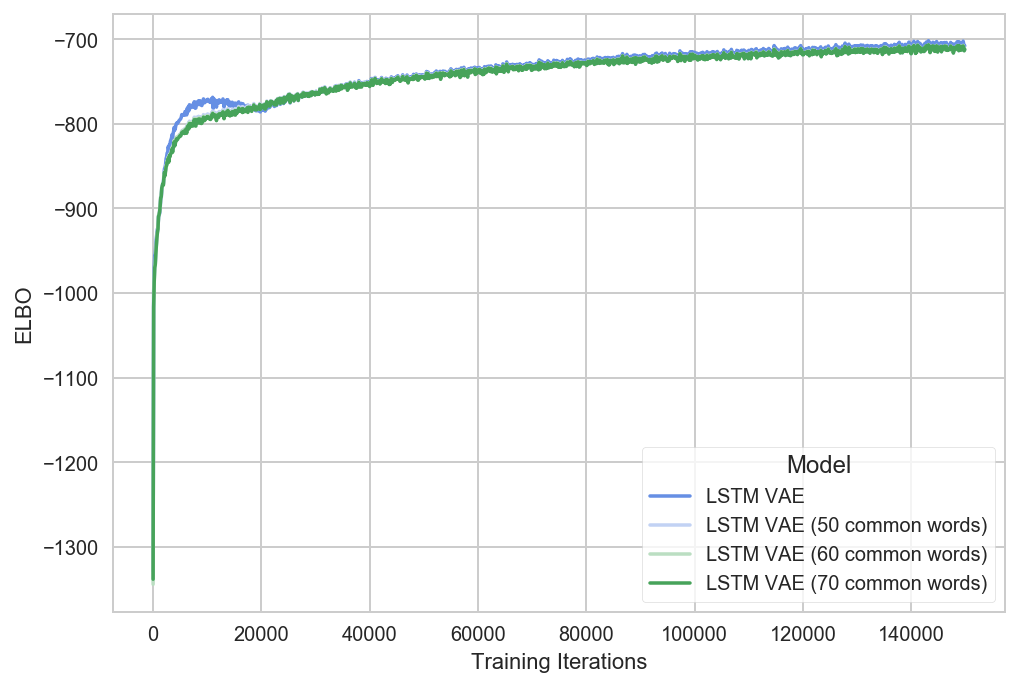

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=1)

sns.set(style='whitegrid', palette=sns.diverging_palette(255, 133, l=60, n=4))

plt.plot(reduced_elbos['GenStanfordWords20000_11to30All'], label='LSTM VAE')
plt.plot(reduced_elbos['GenStanfordWords20000_11to30Top50'], label='LSTM VAE (50 common words)')
plt.plot(reduced_elbos['GenStanfordWords20000_11to30Top60'], label='LSTM VAE (60 common words)')
plt.plot(reduced_elbos['GenStanfordWords20000_11to30Top70'], label='LSTM VAE (70 common words)')

axs.set_xlabel('Training Iterations')
axs.set_ylabel('ELBO')
# axs.set_xlim(0, 8000)
axs.set_xticklabels(['', 0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, ''])

axs.legend(frameon=True, title='Model')
plt.plot()
plt.savefig('./comparison_20K.', format='pdf', dpi=1200)

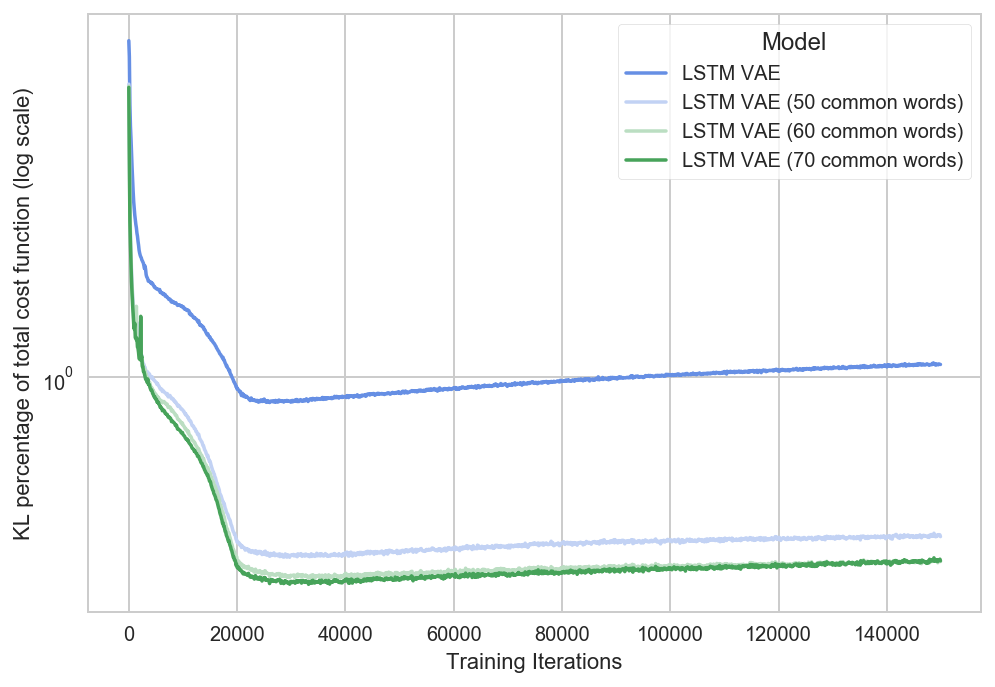

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=1)

plt.semilogy(reduces_pct['GenStanfordWords20000_11to30All'], label='LSTM VAE')
plt.semilogy(reduces_pct['GenStanfordWords20000_11to30Top50'], label='LSTM VAE (50 common words)')
plt.semilogy(reduces_pct['GenStanfordWords20000_11to30Top60'], label='LSTM VAE (60 common words)')
plt.semilogy(reduces_pct['GenStanfordWords20000_11to30Top70'], label='LSTM VAE (70 common words)')

axs.set_xlabel('Training Iterations')
axs.set_ylabel('KL percentage of total cost function (log scale)')
# axs.set_xlim(0, 8000)
# axs.set_ylim(0, 0.5)
axs.set_xticklabels(['', 0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, ''])

axs.legend(frameon=True, title='Model')
plt.plot()
plt.savefig('./kl_perc_20K.pdf', format='pdf', dpi=1200)

In [78]:
names = []
elbos = {}
kls = {}
pps = {}
for f in os.scandir('output/BookCorpus/',):
    if f.is_dir():
        dir_name = f.name
        names.append(dir_name)
        for file in os.scandir(f.path):
            if file.name.endswith('.log'):
                elbos[dir_name] = []
                kls[dir_name] = []
                pps[dir_name] = []
                with open(os.path.join('output/', f.name, file.name)) as fh:
                    for i, line in enumerate(fh):
                        if re.search('Iteration [0-9]*?', line):
                            elbos[dir_name].append(np.float64(re.search('(?<=ELBO = )(-[0-9]+.[0-9]+)', line).group(0)))
                            kls[dir_name].append(np.float64(re.search('(?<=KL = )([0-9]+.[0-9]+)', line).group(0)))
                            pps[dir_name].append(np.float64(re.search('(?<=PP = )([0-9]+.[0-9]+)', line).group(0)))

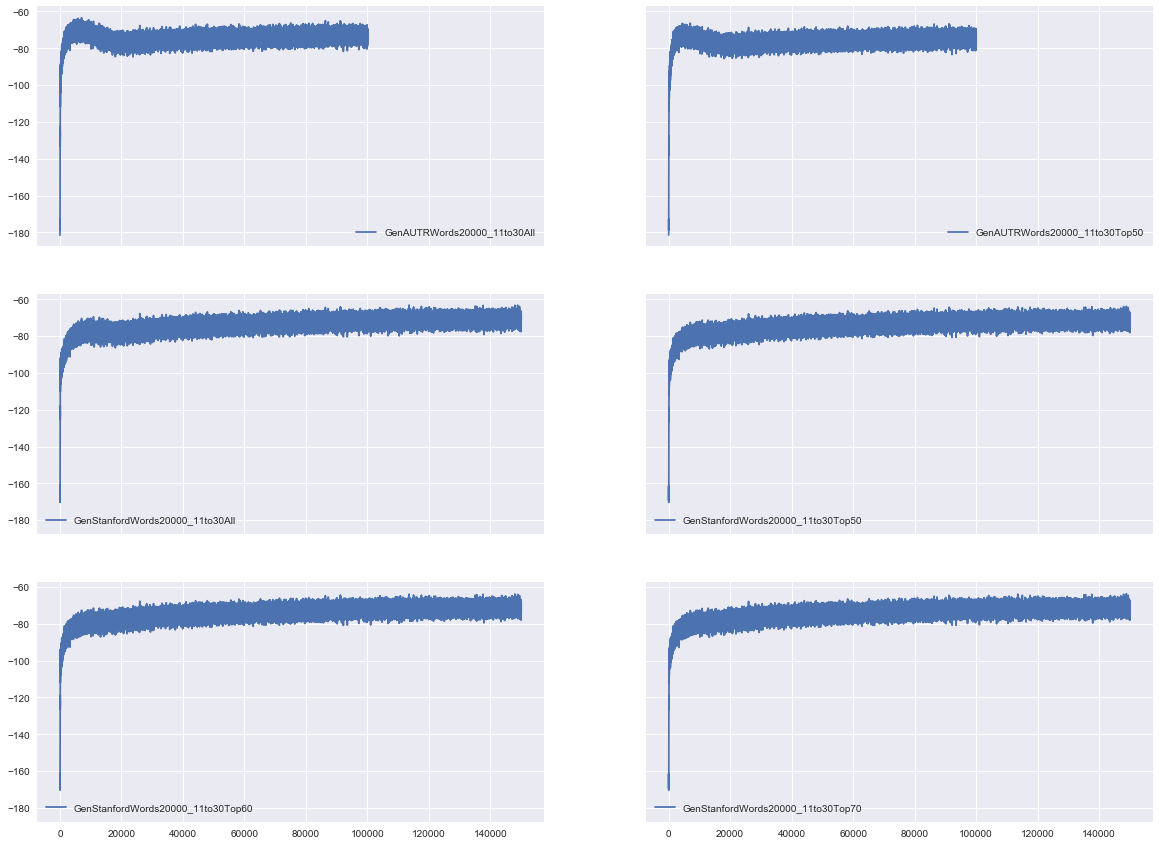

In [82]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize = (20,15))

for i, k in enumerate(sorted(elbos.keys())):
    axs.flatten()[i].plot(elbos[k], label=k)
    axs.flatten()[i].legend()

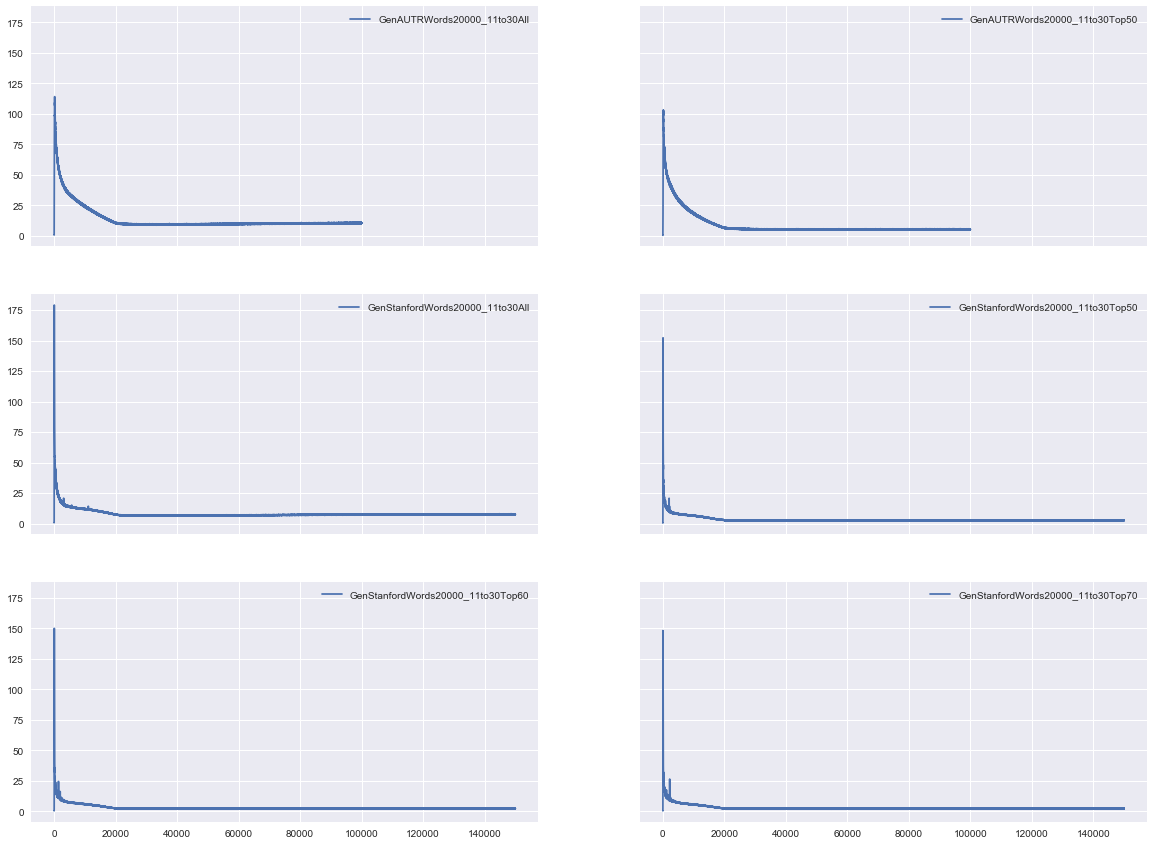

In [83]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize = (20,15))

for i, k in enumerate(sorted(kls.keys())):
    axs.flatten()[i].plot(kls[k], label=k)
    axs.flatten()[i].legend()